# Features for first learning
|feature|mean|
|-|-|
|1stFlrSF|1Fの広さ|
|2ndFlrSF|2Fの広さ|
|TotalBsmtSF|地下の広さ|
|TotalSF|合計の広さ|
|YearBuilt|築年数|
|OverallQual|材質|
|GrLivArea|リビングの広さ|

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)

train = pd.read_csv('./data/train.csv')
test_x  = pd.read_csv('./data/test.csv')


In [ ]:
train['TotalSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF']
test_x['TotalSF'] = test_x['1stFlrSF'] + test_x['2ndFlrSF'] + test_x['TotalBsmtSF']

In [10]:
# トレーニングにだけしたい処理

# 外れ値の削除（合計の広さ）
train = train[(train['TotalSF'] > 700) & (train['TotalSF'] <= 7500)]

# 外れ値の削除（築年数）
mask1 = (train['YearBuilt'] > 1900) | (train['SalePrice'] < 400000)
mask2 = (train['SalePrice'] < 700000)
train = train[mask1 & mask2]

# 外れ値の削除（家の材質）
drop_indices1 = train[(train['OverallQual'] < 5) & (train['SalePrice'] > 200000)].index
drop_indices2 = train[(train['OverallQual'] < 10) & (train['SalePrice'] > 500000)].index
train = train.drop(drop_indices1)
train = train.drop(drop_indices2)
train = train[(train['OverallQual'] < 10) | (train['SalePrice'] < 600000)]

In [11]:
train_x = train.drop('SalePrice',axis=1)
train_y = train['SalePrice']

In [12]:
# データ結合
all_x = pd.concat([train_x, test], axis=0)

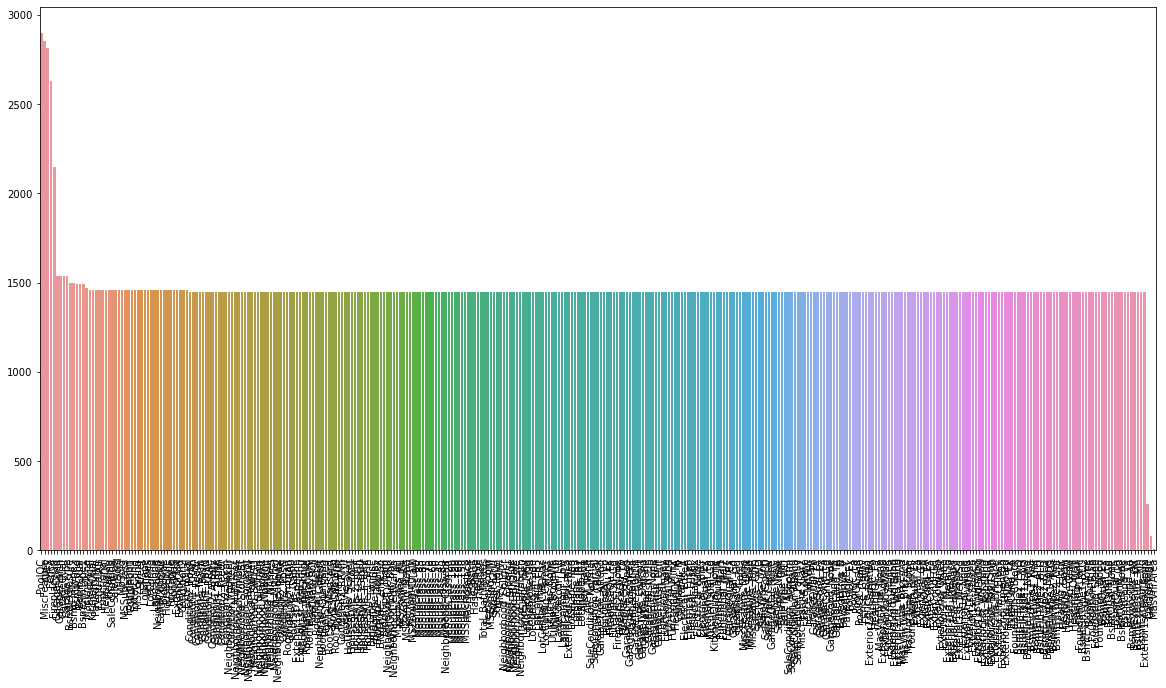

In [13]:
# 欠損値の確認
all_x_na = all_x.isnull().sum()[all_x.isnull().sum() > 0].sort_values(ascending=False)
all_x_na
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=all_x_na.index, y=all_x_na)

# 各欠損値の意味とdrop or mean or median
## PoolDC
プールのクオリティ、存在しない場合は欠損値
**drop**

## MiscFeature
他の特徴量でカバーされていない特筆事項（テニスコートやエレベーターなど）、特に無い場合は欠損値
**drop**

## Alley
物件までの道の種類（砂利とかそういうの）
**drop**

## Fence
フェンスの材質、無い場合は欠損値
**drop**

## FireplaceQu
暖炉の質
**drop**

## LotFrontage
物件に隣接した道路の長さ
**drop**

In [ ]:
# 欠損値のあるカラムのデータ型を確認
na_columns = all_x.isnull().sum()[all_x.isnull().sum()>0].index.tolist()

all_x[na_columns].dtypes.sort_values()

In [ ]:
# 隣接した道の長さは同じ地区の中央値にする
all_x['LotFrontage'] = all_x.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# 欠損値がfloat型
na_floats = all_x[na_columns].dtypes[all_x[na_columns].dtypes == 'float64'].index.tolist()
all_x[na_floats] = all_x[na_floats].fillna(0)

 # 欠損値がobject型
na_objects = all_x[na_columns].dtypes[all_x[na_columns].dtypes == 'object'].index.tolist()
all_x[na_objects] = all_x[na_objects].fillna('None')

all_x.isnull().sum()[all_x.isnull().sum() > 0]

In [ ]:
# カテゴリ変数に変換
all_x['MSSubClass'] = all_x['MSSubClass'].astype(str)

# 売れた年と月は関係なさそうなのでdrop
all_x = all_x.drop(['YrSold', 'MoSold'],axis=1)

In [ ]:
sns.distplot(train_y)
plt.show()
# 目的変数を対数変換する
train_y_log = np.log1p(train_y)
sns.distplot(train_y_log)
plt.show()


In [ ]:
# 特徴量追加

# 部屋の広さの合計
all_x["TotalSF"] = all_x["1stFlrSF"] + all_x["2ndFlrSF"] + all_x["TotalBsmtSF"]

# 1部屋あたりの広さ
all_x["FeetPerRoom"] =  all_x["TotalSF"] / all_x["TotRmsAbvGrd"]

#バスルームの合計面積
all_x['Total_Bathrooms'] = (all_x['FullBath'] + (0.5 * all_x['HalfBath']) +
                               all_x['BsmtFullBath'] + (0.5 * all_x['BsmtHalfBath']))

# 2Fの有無
all_x['Has2F'] = all_x['2ndFlrSF'].apply(lambda x: 1 if x >= 1 else 0)

# プールの有無
all_x['HasPool'] = all_x['PoolArea'].apply(lambda x: 1 if x >= 1 else 0)

#ガレージの有無
all_x['HasGarage'] = all_x['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

#地下室の有無
all_x['HasBsmt'] = all_x['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

#暖炉の有無
all_x['HasFireplace'] = all_x['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)



In [ ]:
# カテゴリ変数の処理

category_columns = all_x.dtypes[all_x.dtypes=="object"].index.tolist()

# one hot encording
all_x = pd.get_dummies(all_x,columns=category_columns)
print(all_x.columns)

In [ ]:
#学習データとテストデータに再分割
train_x = all_x.iloc[:train_x.shape[0],:].reset_index(drop=True)
test = all_x.iloc[train_x.shape[0]:,:].reset_index(drop=True)

In [ ]:
# XGBOOSTのモデル作る
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb


# トレーニングを評価データに分ける
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.4, random_state=999)

# 勾配ブースティングに対応させる
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# ハイパーパラメータ
evals = [(dvalid, 'eval'), (dtrain, 'train')]

evals_result = {}

param = {
    'max_depth': 3, 
    'eta': 0.01,
    'objective': 'reg:reg:squarederror',
}

# 学習
bst=xgb.train(param, dtrain, num_boost_round=133)
